# Рекомендация тарифов

22В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
# подключим библиотеку для работы с таблицей 
import pandas as pd
# импортируем библиотеку для математических вычислений
import numpy as np
# импортируем библиотеку для построение графиков
import matplotlib.pyplot as plt
# подключим библиотеку для разбиения выборок
from sklearn.model_selection import train_test_split
# импортируем модель дерево принятия решений
from sklearn.tree import DecisionTreeClassifier
# <Импортируем метод оценки доли правильных ответов>
from sklearn.metrics import accuracy_score
# импортируем модель случайный лес
from sklearn.ensemble import RandomForestClassifier
# Импортируем алгоритм случайного поиска по гиперпараметрам
from sklearn.model_selection import RandomizedSearchCV
# <Импортируем метод логистической регрессии>
from sklearn.linear_model import LogisticRegression
# импортируем библиотеку случайных чисел
import random as random

<div class="alert alert-info">
<font size="5"><b>Исправление №1</b></font>
Все импорты перенес в верхнюю часть своей работы 
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:

Привет Виталий!

👍




</div>


In [2]:
# скачаем дата сет
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
# просмотрим содержимое скаченного дата сета
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
# посмотрим на структуру данных в дата сете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


<div class="alert alert-info">
<font size="5"><b>Исправление №1</b></font>
Добавил анализ данных импортированной таблице
</div>

In [6]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


<div class="alert alert-info">
<font size="5"><b>Исправление №1</b></font>
Добавил связь по корреляции признаков. Здесь прослеживается только одна сильная связь: это звонки и минуты (0,982). Незначительная связь это количество звонков и минут с использованием интернета (0,28). Остальные звязи менее выражены 
</div>

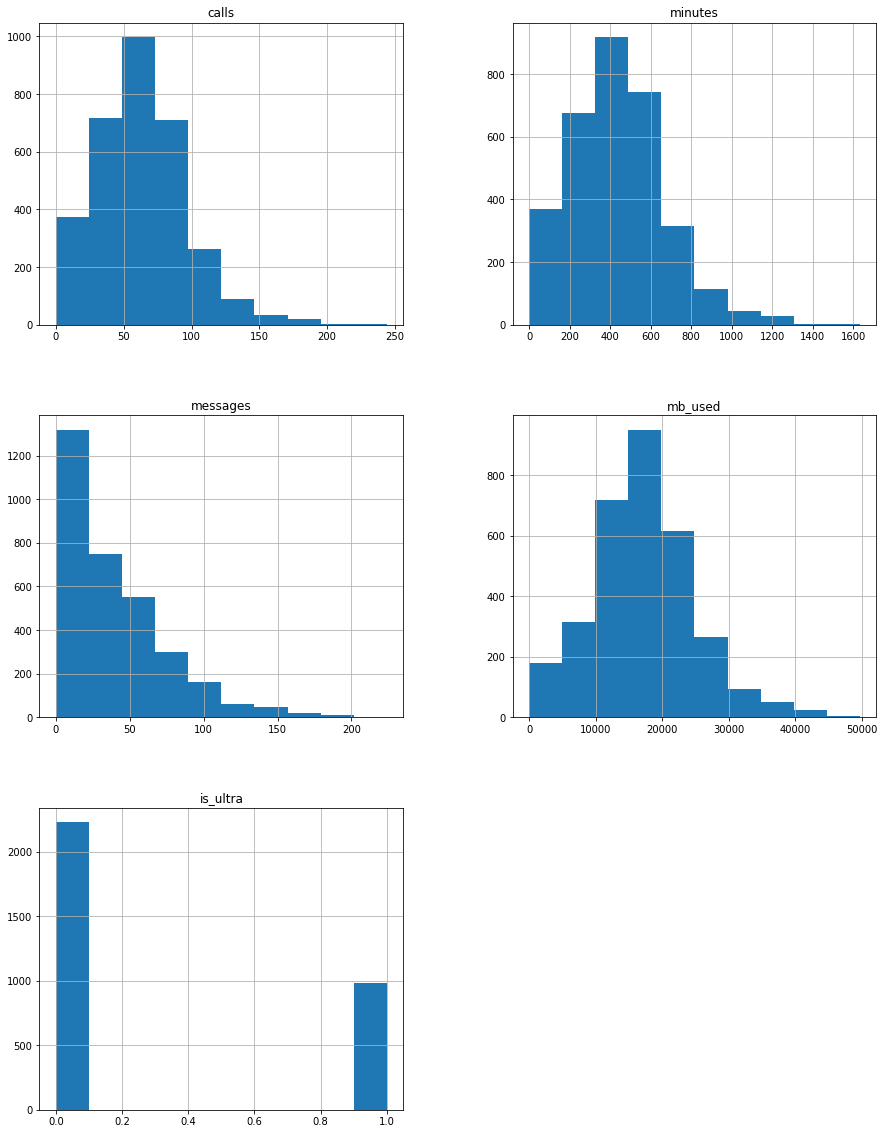

In [7]:
df.hist(figsize=(15, 20));

Структура данных нормальная. Выбросов и аномалий не наблюдается.

In [8]:
# построим сводную таблицу и посмотрим какое соотношение на одном и на втором тарифе
df.groupby('is_ultra')[['calls','minutes','messages','mb_used']].sum()

,calls,minutes,messages,mb_used
is_ultra,,,,
0,130315.0,904846.84,74413.0,36128672.83
1,72292.0,503556.20,48623.0,19176790.88


По тарифу "Ультра" осуществляется меньше звонков практически в два раза, также практически в два раза меньше минут и сообщений. расход по интернет трафику тоже снижен в два раза. Нужно проверить количество пользователей на каждом тарифе

In [9]:
df.groupby('is_ultra')['calls'].count()

is_ultra
0    2229
1     985
Name: calls, dtype: int64

Так и есть количество пользователей на тарифе "Ультра" почти в два раза меньше чем на тарифе "Смарт". Сделаем анализ среднего значения и сравним их.

In [10]:
df.groupby('is_ultra')[['calls','minutes','messages','mb_used']].mean()

,calls,minutes,messages,mb_used
is_ultra,,,,
0,58.463437,405.942952,33.384029,16208.466949
1,73.392893,511.224569,49.363452,19468.823228


А вот по средним значениям картина складывается совсем по другому! Тариф "Ультра" намного выгоден чем тариф "Смарт" 

Вывод: Проанализировал состав данных в датасете, нет никаких отклонений. 
Анализ по сводным таблицам показал следующее: 
Абоненты на тарифе "Ультра" по стравнению с тарифом "Сматр" значительно больше осуществляют количество звонков (на 25%), больше общаются по минутам (на 20%), больше отправляют смски (на 48%), и соотсветственно больше используют интернет (на 17%)

## Разбейте данные на выборки

In [11]:
# подключим библиотеку для разбиения выборок
#from sklearn.model_selection import train_test_split

<div class="alert alert-info">
<font size="5"><b>Исправление №1</b></font>
Импорт перенес в верхнюю часть своей работы 
</div>

In [12]:
# отделим 40% данных выборки для  обучения
df_train, df_never = train_test_split(df, test_size =0.4, random_state = 12345)

In [13]:
# проверим объем полученных данных всего данных 3214 если 60%  то получается 1928 все верно
df_train.shape

(1928, 5)

<div class="alert alert-info">
<font size="5"><b>Исправление №1</b></font>
сделана проверка полноты данных на тренеровочной выборке 
</div>

In [14]:
# проверим объем полученных данных всего данных 3214 если 40%  то получается 1286 все верно
df_never.shape

(1286, 5)

<div class="alert alert-info">
<font size="5"><b>Исправление №1</b></font>
сделана проверка полноты данных на промежуточной выборке 
</div>

In [15]:
# отделим по 20% на валидную и тестовую выборку
df_valid, df_test = train_test_split(df_never,test_size=0.5, random_state = 12345)

In [16]:
# проверим объем полученных данных всего данных 3214 если 20%  то получается 643 все верно
df_valid.shape

(643, 5)

<div class="alert alert-info">
<font size="5"><b>Исправление №1</b></font>
сделана проверка полноты данных на валидной выборке 
</div>

In [17]:
# проверим объем полученных данных всего данных 3214 если 20%  то получается 643 все верно
df_test.shape

(643, 5)

<div class="alert alert-info">
<font size="5"><b>Исправление №1</b></font>
сделана проверка полноты данных на тестовой выборке 
</div>

In [18]:
# Определим признаки выборки для обучения, валидации и теста
features_train = df_train.drop(['is_ultra'],axis=1)
features_valid = df_valid.drop(['is_ultra'],axis=1)
features_test  = df_test.drop(['is_ultra'],axis=1)

In [19]:
# Определим целевой признак
target_train = df_train['is_ultra']
target_valid = df_valid['is_ultra']
target_test  = df_test['is_ultra']

Вывод: Мы выделили основные признаки и целевой признак для дальнейшего обучения и выбора лучшей модели. Разбили выборки на обучающую, валидационную и тестовую.

## Исследуйте модели

In [20]:
# импортируем модель дерево принятия решений
#from sklearn.tree import DecisionTreeClassifier
# <Импортируем метод оценки доли правильных ответов>
#from sklearn.metrics import accuracy_score

<div class="alert alert-info">
<font size="5"><b>Исправление №1</b></font>
Импорт перенес в верхнюю часть своей работы 
</div>

Accuracy: 0.7542768273716952 depth 1
Accuracy: 0.7822706065318819 depth 2
Accuracy: 0.7853810264385692 depth 3
Accuracy: 0.7853810264385692 depth 4
Accuracy: 0.7869362363919129 depth 5
Accuracy: 0.7884914463452566 depth 6
Accuracy: 0.7853810264385692 depth 7
Accuracy: 0.7853810264385692 depth 8
Accuracy: 0.7853810264385692 depth 9
Accuracy: 0.7807153965785381 depth 10
Best_resultAccuracy: 0.7884914463452566 depth 6


[]

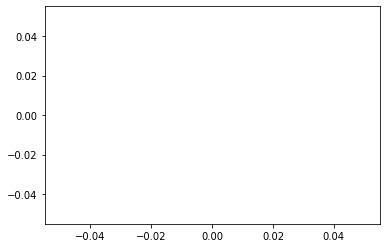

In [21]:
# зададим переменные
best_result = 0
best_depth = 0
train_spisok = []
valid_spisok = []

# сделаем цикл по глубине дерева
for depth in range(1,10):
    # инициализируем модель "Дерево принятие решений"
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth, min_samples_split= 110)
    # обучаем модель на тренеровочной выборке
    model.fit(features_train, target_train)
    # получим предсказания на валидной выборке
    predictions_valid = model.predict(features_valid)    
    accuracy = accuracy_score(target_valid, predictions_valid)
    print("Accuracy:", accuracy, "depth",depth)
    if accuracy > best_result:
        best_result = accuracy
        best_depth = depth
print("Best_resultAccuracy:", best_result, "depth", best_depth)
plt.plot()

доля правильных ответов 78,84% при глубине дерева равной 6. Любые опыты с критерием и весом классов (balanced) ухудшали результат при min_samples_split = 100.

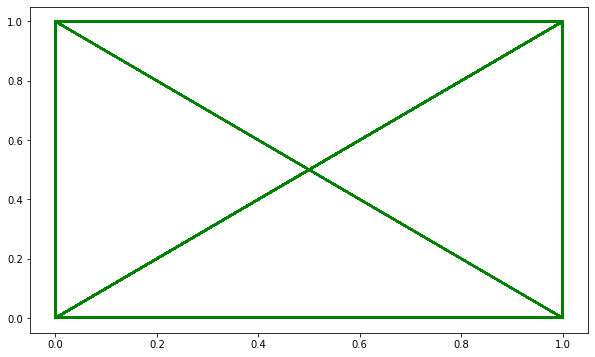

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(target_valid, predictions_valid, "g", lw=2)


In [23]:
# импортируем модель случайный лес
#from sklearn.ensemble import RandomForestClassifier

<div class="alert alert-info">
<font size="5"><b>Исправление №1</b></font>
Импорт перенес в верхнюю часть своей работы 
</div>

In [24]:
# зададим переменные
best_result = 0
best_depth = 0

# сделаем цикл по количеству деревьев 10 до 50 с шагом 10
for est in range(10,30,2):
    for depth in range(1,11):
        # инициализируем модель "Дерево случайный лес"
        model = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth=depth)
        # обучаем модель на тренеровочной выборке
        model.fit(features_train,target_train)
        # получим предсказания на валидной выборке
        prediction_valid = model.predict(features_valid)
        # посчитаем значение на валидационной выборке
        accuracy = accuracy_score(target_valid, prediction_valid)
        print("Accuracy:", accuracy, "est", est, "depth",depth)
        if accuracy > best_result:
            best_result = accuracy
            best_depth = depth
print("Best_result_Accuracy:", best_result, "est", est, "best_depth", best_depth)

Accuracy: 0.7558320373250389 est 10 depth 1
Accuracy: 0.7776049766718507 est 10 depth 2
Accuracy: 0.7853810264385692 est 10 depth 3
Accuracy: 0.7900466562986003 est 10 depth 4
Accuracy: 0.7931570762052877 est 10 depth 5
Accuracy: 0.8009331259720062 est 10 depth 6
Accuracy: 0.7947122861586314 est 10 depth 7
Accuracy: 0.7962674961119751 est 10 depth 8
Accuracy: 0.7853810264385692 est 10 depth 9
Accuracy: 0.7916018662519441 est 10 depth 10
Accuracy: 0.7667185069984448 est 20 depth 1
Accuracy: 0.7838258164852255 est 20 depth 2
Accuracy: 0.7869362363919129 est 20 depth 3
Accuracy: 0.7884914463452566 est 20 depth 4
Accuracy: 0.7900466562986003 est 20 depth 5
Accuracy: 0.7993779160186625 est 20 depth 6
Accuracy: 0.8009331259720062 est 20 depth 7
Accuracy: 0.7978227060653188 est 20 depth 8
Accuracy: 0.7900466562986003 est 20 depth 9
Accuracy: 0.7916018662519441 est 20 depth 10
Accuracy: 0.7667185069984448 est 30 depth 1
Accuracy: 0.7838258164852255 est 30 depth 2
Accuracy: 0.7869362363919129 e

Результат равен 80,87% количество деревьев 40 и максимальной глубиной 8 немного лучше. Проверим эту модель на тестовой выборке.

In [25]:
# Импортируем алгоритм случайного поиска по гиперпараметрам
#from sklearn.model_selection import RandomizedSearchCV

<div class="alert alert-info">
<font size="5"><b>Исправление №1</b></font>
Импорт перенес в верхнюю часть своей работы 
</div>

In [26]:
# сетка гиперпараметров, по которой будет происходит случайный поиск
param_grid = {
    'n_estimators': np.linspace(2, 100).astype(int),
    'max_depth': [None] + list(np.linspace(2, 10).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0, 5, 1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

<div class="alert alert-info">
<font size="5"><b>Исправление №1</b></font>
Ошибка исправлена, забыл перенести (вставить) импорт np для работы кода
</div>

In [27]:
# дерево случайный лес к которому будем подбирать параметры
estimator = RandomForestClassifier(random_state = 12345)

In [28]:
# модель
rs = RandomizedSearchCV(estimator, param_grid, random_state=12345)

In [29]:
# обучаем модель 
rs.fit(features_train, target_train)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=12345),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 2, 2, 2, 2, 2, 2, 2,
                                                      3, 3, 3, 3, 3, 3, 4, 4, 4,
                                                      4, 4, 4, 5, 5, 5, 5, 5, 5,
                                                      6, 6, 6, 6, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0, 1, 2, 3, 4],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 11,
                                                           11, 11, 11, 11, 11,
                                                           11, 11, 11, 11,

In [30]:
# набор параметров, которые подобрал случайный поиск
rs.best_params_

{'n_estimators': 84,
 'min_samples_split': 5,
 'max_leaf_nodes': 17,
 'max_features': 3,
 'max_depth': 8,
 'bootstrap': True}

In [31]:
# предскажем целевой признак и подсчитаем долю правильных ответов.
predictions = rs.predict(features_valid)
accuracy = accuracy_score(target_valid, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7900466562986003


Вывод: Результат получили немного хуче, но все равно проверим его на тестовой выборке

In [32]:
# <Импортируем метод логистической регрессии>
#from sklearn.linear_model import LogisticRegression

<div class="alert alert-info">
<font size="5"><b>Исправление №1</b></font>
Импорт перенес в верхнюю часть своей работы 
</div>

In [33]:
model = LogisticRegression(random_state=12345)
# обучаем модель на тренеровочной выборке
model.fit(features_train,target_train)
# получим предсказания на валидной выборке
prediction_valid = model.predict(features_valid)
# получим предсказания на валидной выборке
prediction_valid = model.predict(features_valid)
# посчитаем значение на валидационной выборке
accuracy = accuracy_score(target_valid, prediction_valid)
print("Accuracy:", accuracy)

Accuracy: 0.7107309486780715


Результат получили хуче чем у остальных.Я осмотрел некоторые гиперпараметры типа solver, class_weight, max_iter и попробовал покрутить их, но они или давали тот же самый результат или еще сильней ухудшали его

Вывод:
 - Обучил дерево принятие решений на тренеровочной выборке и проверил результат на валидной выборке доля правильных ответов 78,84% при глубине дерева равной 6
 - обучил дерево случайный лес. Результат равен 80,87% количество деревьев 40 и максимальной глубиной 8
 - Построил модель на Логистической регрессии, результат самый низкий 71,07%.
 - Открыл для себя несколько  интересных методов, гиперпараметров, потренировались подбирать параметры

## Проверьте модель на тестовой выборке

In [34]:
# для проверки выберем нашу модель которая набрала самый высокий процент качества "Дерево случайного леса"
model = RandomForestClassifier(random_state = 12345, n_estimators = 40, max_depth=8)
# обучаем модель на тренеровочной выборке
model.fit(features_train,target_train)
# получим предсказания на валидной выборке
prediction_valid = model.predict(features_test)
# посчитаем значение на валидационной выборке
accuracy = accuracy_score(target_test, prediction_valid)
print("Accuracy:", accuracy)

Accuracy: 0.7962674961119751


Результ получился 79,62%, а сейчас давайте проверим с подбором гиперпараметров

In [35]:
# предскажем целевой признак и подсчитаем долю правильных ответов.
predictions = rs.predict(features_test)
accuracy = accuracy_score(target_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.80248833592535


Результат получился практически приблеженный как сделали на валидной выборке. 

Вывод: Модель которая подбиралась гиперпараметрами показывает немного лучше результат, чем та которой мы подобрали глубину и количество деревьев. Мы проверили две лучшие модели на тестовой выборке и получили высокий результат!

## (бонус) Проверьте модели на адекватность

In [36]:
random_predictions = np.random.randint(low = 0, high = 2, size = 643) 

# <подсчитаем долю правильных ответов.>
accuracy = accuracy_score(target_test, random_predictions)

# <выведем долю правильных ответов>
print('accuracy =','{:.4f}'.format(accuracy))

accuracy = 0.5132


Как видим случайные ответы ошибаются примерно в 48,37% случаев. Наша модель ошибается реже - только лишь в 19% случаев.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [ ] Весь код исполняется без ошибок
- [ ] Ячейки с кодом расположены в порядке исполнения
- [ ] Выполнено задание 1: данные загружены и изучены
- [ ] Выполнено задание 2: данные разбиты на три выборки
- [ ] Выполнено задание 3: проведено исследование моделей
    - [ ] Рассмотрено больше одной модели
    - [ ] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [ ] Написаны выводы по результатам исследования
- [ ] Выполнено задание 3: Проведено тестирование
- [ ] Удалось достичь accuracy не меньше 0.75


Обший вывод: Подготовленная модель "Случайный лес" показала хорошие рещультаты для дальнейшего применения в бизнес-Задачах и прошла валидацию качества